In [1]:
import pandas as pd
#import pandas_profiling
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
#from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from math import log as log
import os

pd.options.mode.chained_assignment = None

#for dirname, _, filenames in os.walk('./kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))
PATH_to_file = './kaggle/input/sf-dst-scoring/'

RANDOM_SEED = 42

import warnings
warnings.filterwarnings("ignore")

# # # этот блок закомментирован так как используется только локальной машине
# from importlib import reload
# print(os.listdir('./data'))
# PATH_to_file = './data/'

In [2]:
df_train = pd.read_csv(PATH_to_file+'train.csv')
df_test = pd.read_csv(PATH_to_file+'test.csv')
pd.set_option('display.max_columns', None)
print('Размерность тренировочного датасета: ', df_train.shape)
display(df_train.head(2))
print('Размерность тестового датасета: ', df_test.shape)
display(df_test.head(2))

Размерность тренировочного датасета:  (73799, 19)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0


Размерность тестового датасета:  (36349, 18)


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N


In [3]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

df = df_test.append(df_train, sort=False).reset_index(drop=True)

# Описания полей
client_id - идентификатор клиента

education - уровень образования

sex - пол заемщика

age - возраст заемщика

car - флаг наличия автомобиля

car_type - флаг автомобиля иномарки

decline_app_cnt - количество отказанных прошлых заявок

good_work - флаг наличия “хорошей” работы

bki_request_cnt - количество запросов в БКИ

home_address - категоризатор домашнего адреса

work_address - категоризатор рабочего адреса

income - доход заемщика

foreign_passport - наличие загранпаспорта

sna - связь заемщика с клиентами банка

first_time - давность наличия информации о заемщике

score_bki - скоринговый балл по данным из БКИ

region_rating - рейтинг региона

app_date - дата подачи заявки

default - флаг дефолта по кредиту

In [4]:
bin_columns = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_columns = ['education', 'home_address', 'work_address']
num_columns = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'sna', 'first_time', 'score_bki', 'region_rating']
special_columns = ['app_date']
target_column = 'default'

# Избавимся от пропусков

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [6]:
# заполним пропуски самым частым значением
import collections

edu = collections.Counter(df['education'])
df['education'].fillna(edu.most_common()[0][0], inplace=True)

# Обработаем бинарные данные

In [7]:
bin_columns = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for column in bin_columns:
    df[column] = label_encoder.fit_transform(df[column])
    
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,1,29,1,1,0,0,-2.271884,3,50,1,2,50000,1,4,0,0,0
1,17527,24JAN2014,SCH,0,39,0,0,5,0,-1.504999,2,50,1,2,5000,4,3,0,0,0
2,75683,23MAR2014,UGR,1,50,1,1,0,0,-1.691339,1,50,1,2,30000,1,3,1,0,0
3,26883,03FEB2014,SCH,1,56,0,0,0,0,-2.374182,1,40,1,2,17000,1,3,0,0,0
4,28862,04FEB2014,GRD,0,38,0,0,0,0,-2.487502,0,80,2,3,120000,1,3,0,0,0


# Исключим коррелируемые признаки

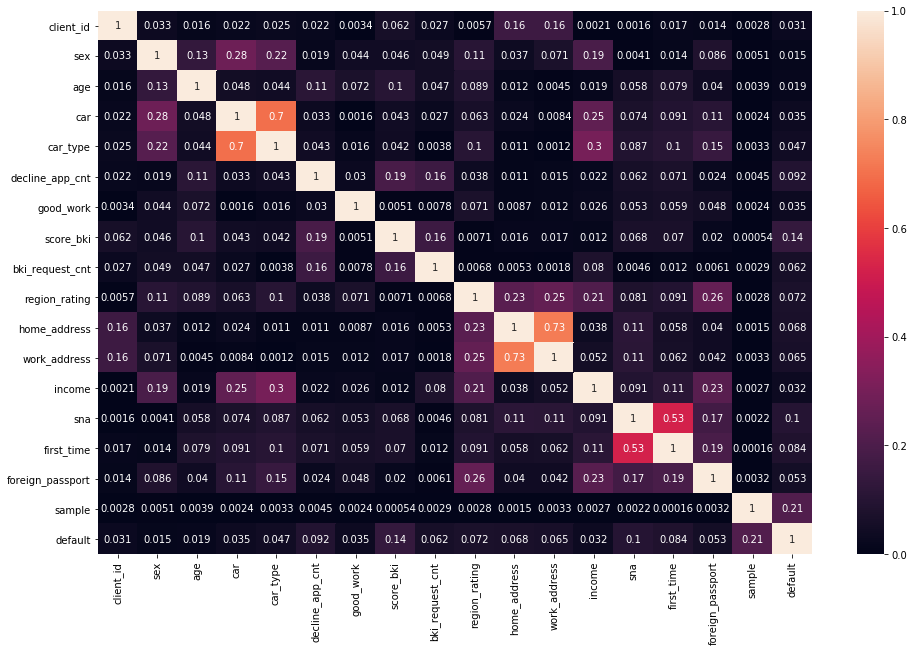

In [9]:
plt.figure(figsize=(16,10))
sns.heatmap(df.corr().abs(), vmin=0, vmax=1, annot=True)

In [10]:
df = df.drop(['car_type', 'work_address'], axis=1)

# Обработаем категориальные признаки
## Превратим их в dummy-переменные

In [11]:
cat_columns = ['education', 'home_address']

In [12]:
education_dict = {'unknown': 0, 'ACD': 1, 'PGR': 2, 'UGR': 3, 'GRD': 4, 'SCH': 5}
df = df.replace({'education': education_dict})

In [13]:
df = pd.get_dummies(df, prefix=cat_columns, prefix_sep='_', columns=cat_columns) 
df.head()

,client_id,app_date,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,sample,default,education_1,education_2,education_3,education_4,education_5,home_address_1,home_address_2,home_address_3
0,74835,22MAR2014,1,29,1,0,0,-2.271884,3,50,50000,1,4,0,0,0,0,0,0,1,0,1,0,0
1,17527,24JAN2014,0,39,0,5,0,-1.504999,2,50,5000,4,3,0,0,0,0,0,0,0,1,1,0,0
2,75683,23MAR2014,1,50,1,0,0,-1.691339,1,50,30000,1,3,1,0,0,0,0,1,0,0,1,0,0
3,26883,03FEB2014,1,56,0,0,0,-2.374182,1,40,17000,1,3,0,0,0,0,0,0,0,1,1,0,0
4,28862,04FEB2014,0,38,0,0,0,-2.487502,0,80,120000,1,3,0,0,0,0,0,0,1,0,0,1,0


# Обработаем app_date

In [14]:
import ast
from datetime import datetime, timedelta 

In [15]:
df['app_date'] = df['app_date'].apply(lambda d: (datetime.today() - datetime.strptime(d,'%d%b%Y')))
df['app_date'] = df['app_date'].dt.days

In [16]:
df.head()

,client_id,app_date,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,sample,default,education_1,education_2,education_3,education_4,education_5,home_address_1,home_address_2,home_address_3
0,74835,2369,1,29,1,0,0,-2.271884,3,50,50000,1,4,0,0,0,0,0,0,1,0,1,0,0
1,17527,2426,0,39,0,5,0,-1.504999,2,50,5000,4,3,0,0,0,0,0,0,0,1,1,0,0
2,75683,2368,1,50,1,0,0,-1.691339,1,50,30000,1,3,1,0,0,0,0,1,0,0,1,0,0
3,26883,2416,1,56,0,0,0,-2.374182,1,40,17000,1,3,0,0,0,0,0,0,0,1,1,0,0
4,28862,2415,0,38,0,0,0,-2.487502,0,80,120000,1,3,0,0,0,0,0,0,1,0,0,1,0


# Проверим значимость переменных

Text(0.5, 0, 'F-value')

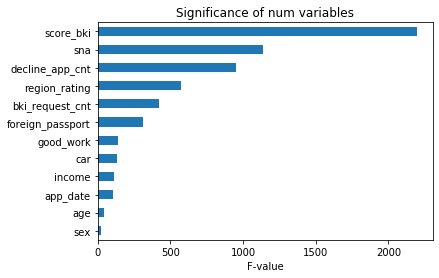

In [17]:
valuable_columns = ['app_date', 'sex', 'age', 'car', 'decline_app_cnt', 'good_work', 'score_bki', 'region_rating', 'income', 'bki_request_cnt', 'sna', 'foreign_passport']
imp_num = pd.Series(f_classif(df[valuable_columns], df['default'])[0], index = valuable_columns)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')
plt.title('Significance of num variables')
plt.xlabel('F-value')

# Добавим полиномиальные признаки

In [18]:
from sklearn.preprocessing import PolynomialFeatures

pf = PolynomialFeatures(2)
poly_columns = ['score_bki', 'bki_request_cnt', 'sna', 'decline_app_cnt', 'region_rating']
poly_features = pf.fit_transform(df[poly_columns])
df = pd.concat([pd.DataFrame(poly_features), df], axis =1)

# Нормализуем признаки

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

non_norm_columns = ['client_id', 'score_bki', 'region_rating', 'first_time', 'default', 'sample', 'sna']
norm_columns = [x for x in list(df.columns) if x not in non_norm_columns]
df[norm_columns] = scaler.fit_transform(df[norm_columns])

In [20]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,client_id,app_date,sex,age,car,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,income,sna,first_time,foreign_passport,sample,default,education_1,education_2,education_3,education_4,education_5,home_address_1,home_address_2,home_address_3
0,0.0,-0.735587,0.438921,-0.651664,-0.341893,-0.516704,0.681949,-0.790360,0.431327,0.347566,-0.144801,-0.004940,-0.093288,-0.165491,0.260818,-0.595373,-0.272238,-0.718417,-0.105264,-0.337303,-0.565923,74835,-0.593234,1.131340,-0.889859,1.439369,-0.341893,-0.445356,-2.271884,0.438921,50,0.197961,1,4,-0.418659,0,0,-0.051467,-0.131238,-0.393181,1.472442,-1.063803,1.123532,-1.085675,-0.131381
1,0.0,0.800039,-0.002207,2.020593,5.915180,-0.516704,-0.855419,0.156900,-1.204867,-5.525094,0.854516,-0.160338,0.871453,1.810562,-0.101299,2.145136,10.018603,1.570344,3.584604,5.245225,-0.565923,17527,1.183799,-0.883907,-0.021654,-0.694749,5.915180,-0.445356,-1.504999,-0.002207,50,-0.793238,4,3,-0.418659,0,0,-0.051467,-0.131238,-0.393181,-0.679144,0.940024,1.123532,-1.085675,-0.131381
2,0.0,0.426908,-0.443335,-0.651664,-0.341893,-0.516704,-0.539283,0.485125,0.684756,0.347566,0.611699,-0.253577,-0.479184,-0.165491,-0.463417,-0.595373,-0.272238,-0.718417,-0.105264,-0.337303,-0.565923,75683,-0.624410,1.131340,0.933372,1.439369,-0.341893,-0.445356,-1.691339,-0.443335,50,-0.242572,1,3,2.388577,0,0,-0.051467,-0.131238,2.543359,-0.679144,-1.063803,1.123532,-1.085675,-0.131381
3,0.0,-0.940432,-0.443335,-0.651664,-0.341893,-1.282058,0.934221,0.315160,0.386669,0.347566,0.340648,-0.253577,-0.479184,-0.165491,-0.535840,-0.595373,-0.272238,-0.871002,-0.105264,-0.337303,-1.137297,26883,0.872039,1.131340,1.454295,-0.694749,-0.341893,-0.445356,-2.374182,-0.443335,40,-0.528918,1,3,-0.418659,0,0,-0.051467,-0.131238,-0.393181,-0.679144,0.940024,1.123532,-1.085675,-0.131381
4,0.0,-1.167347,-0.884463,-0.651664,-0.341893,1.779355,1.226642,0.906114,0.337201,0.347566,-2.370632,-0.284656,-0.672132,-0.165491,-0.825535,-0.595373,-0.272238,-0.260665,-0.105264,-0.337303,1.910030,28862,0.840863,-0.883907,-0.108474,-0.694749,-0.341893,-0.445356,-2.487502,-0.884463,80,1.739828,1,3,-0.418659,0,0,-0.051467,-0.131238,-0.393181,1.472442,-1.063803,-0.890051,0.921086,-0.131381


# Регуляризация

In [21]:
from sklearn.model_selection import GridSearchCV

def regularization(X_train, y_train):
    # Зададим ограничения для параметра регуляризации
    C = np.logspace(0, 4, 10)

    penalty = ['l1', 'l2']
    hyperparameters = dict(C=C, penalty=penalty)
    model = LogisticRegression()
    model.fit(X_train, y_train)

    clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

    best_model = clf.fit(X_train, y_train)
    
    best_penalty = best_model.best_estimator_.get_params()['penalty']
    best_c = best_model.best_estimator_.get_params()['C']

    print('Лучший penalty:', best_penalty)
    print('Лучшее C:', best_c)
    return best_penalty, best_c

# Создаем модель, обучаем и тестируем

In [22]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score 
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score 
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

def calc_metrics(y_test, y_pred, probs):
    display('ROC_AUC:', roc_auc_score(y_test, probs))
    
    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label = 'Regression')
    plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc = 'lower right')
    plt.show()
    
    display(confusion_matrix(y_test, y_pred))

In [23]:
def train_model(X_train, X_test, y_train, y_test, best_penalty, best_C):        
    model = LogisticRegression(penalty = best_penalty, C=best_C)
    #model = LogisticRegression(random_state=RANDOM_SEED)
    model.fit(X_train, y_train)    
    
    y_pred_prob = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    
    calc_metrics(y_test, y_pred, y_pred_prob)   
    
    return model

In [24]:
columns_to_drop = ['client_id', 'sample']

train_data = df.query('sample == 1.0').drop(columns_to_drop, axis=1)
test_data = df.query('sample == 0.0').drop(columns_to_drop, axis=1)

y = train_data['default'].values
X = train_data.drop(['default'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_SEED)       

best_penalty, best_c = regularization(X_train, y_train)

Лучший penalty: l2
Лучшее C: 7.742636826811269


'ROC_AUC:'

0.7345745882632736

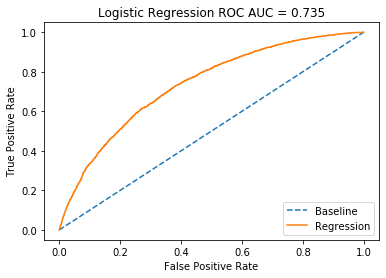

array([[19306,    54],
       [ 2738,    42]])

In [25]:
model = train_model(X_train, X_test, y_train, y_test, best_penalty, best_c)

# Сохраняем результат

In [26]:
#Используем весь датасет для обучения
model = LogisticRegression(penalty = best_penalty, C=best_c, max_iter=500)
model.fit(X, y)

LogisticRegression(C=7.742636826811269, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [27]:
test_data = test_data.drop(['default'], axis=1)
predict_submission = model.predict_proba(test_data)[:,1]
#predict_submission = [round_rating(x) for x in predict_submission]    

df_test['default'] = predict_submission
df_test[['client_id', 'default']].to_csv('submission.csv', index=False)
df_test.head(10)

#y_pred_prob = model.predict_proba(X_test)[:,1]


#submit = pd.DataFrame(df_test.client_id)
#submit['default']=y_pred_prob
#submit.to_csv('submission.csv', index=False)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0.040860
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0.299080
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0.065404
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0.076733
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0.020626
5,99881,17APR2014,SCH,F,55,N,N,0,0,-1.740224,7,50,3,3,30000,2,1,N,0,0.175408
6,26630,02FEB2014,SCH,F,30,N,N,3,0,-1.387847,5,60,1,2,11000,4,3,N,0,0.277364
7,79934,28MAR2014,GRD,M,41,Y,Y,0,0,-3.066047,3,60,1,3,80000,4,1,N,0,0.035432
8,16605,23JAN2014,GRD,M,34,N,N,0,0,-3.117086,0,80,2,3,5000,1,2,N,0,0.015560
9,105449,24APR2014,UGR,M,28,Y,Y,0,0,-2.185172,0,80,2,3,80000,1,3,Y,0,0.025531


In [28]:
df_test[['client_id', 'default']].head()

,client_id,default
0,74835,0.040860
1,17527,0.299080
2,75683,0.065404
3,26883,0.076733
4,28862,0.020626
